In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [2]:
# Dataset Prep
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

train_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/train", transform=transform)
val_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/validation", transform=transform)
test_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/test", transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
# Load VGG16 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier[6] = nn.Linear(4096, 15)  
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s]  


In [4]:
# Training and Validation Loop
num_epochs = 30
metrics = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(num_epochs):
    # Training Phase
    vgg16.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    metrics["train_loss"].append(running_loss / len(train_loader))
    
    # Validation Phase
    vgg16.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["val_accuracy"].append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {correct / total:.4f}")

torch.save(vgg16.state_dict(), "vgg16_finetuned.pth")

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/30, Train Loss: 2.7550, Val Loss: 2.6986, Val Accuracy: 0.0886
Epoch 2/30, Train Loss: 2.7184, Val Loss: 2.6976, Val Accuracy: 0.1026
Epoch 3/30, Train Loss: 2.6979, Val Loss: 2.6985, Val Accuracy: 0.1026
Epoch 4/30, Train Loss: 2.6971, Val Loss: 2.6949, Val Accuracy: 0.1026
Epoch 5/30, Train Loss: 2.6960, Val Loss: 2.6937, Val Accuracy: 0.1026
Epoch 6/30, Train Loss: 2.6948, Val Loss: 2.6924, Val Accuracy: 0.1026
Epoch 7/30, Train Loss: 2.6957, Val Loss: 2.6920, Val Accuracy: 0.1026
Epoch 8/30, Train Loss: 2.6950, Val Loss: 2.6922, Val Accuracy: 0.1026
Epoch 9/30, Train Loss: 2.6952, Val Loss: 2.6914, Val Accuracy: 0.1026
Epoch 10/30, Train Loss: 2.6940, Val Loss: 2.6915, Val Accuracy: 0.1026
Epoch 11/30, Train Loss: 2.6952, Val Loss: 2.6912, Val Accuracy: 0.1026
Epoch 12/30, Train Loss: 2.6943, Val Loss: 2.6916, Val Accuracy: 0.1026
Epoch 13/30, Train Loss: 2.6943, Val Loss: 2.6928, Val Accuracy: 0.1026
Epoch 14/30, Train Loss: 2.6942, Val Loss: 2.6927, Val Accuracy: 0.1026
E

In [5]:
# Load Fine-Tuned Model
# vgg16 = models.vgg16(pretrained=False)  # Load VGG16 architecture
# vgg16.classifier[6] = nn.Linear(4096, 3)  # Adjust output layer for 3 classes
# vgg16.load_state_dict(torch.load("vgg16_finetuned.pth"))  # Load fine-tuned weights
# vgg16 = vgg16.to(device)

# Test Eval
vgg16.eval()  
test_labels = []
test_preds = []
test_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# Metrics

test_labels_one_hot = label_binarize(test_labels, classes=range(15))  

precision = precision_score(test_labels, test_preds, average="macro")
recall = recall_score(test_labels, test_preds, average="macro")
f1 = f1_score(test_labels, test_preds, average="macro")
map_score = average_precision_score(test_labels_one_hot, test_probs, average="macro")

print(f"Test Metrics:\n"
      f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1-Score: {f1:.4f}\n"
      f"mAP: {map_score:.4f}")

correct = sum([1 for true, pred in zip(test_labels, test_preds) if true == pred])
accuracy = correct / len(test_labels)

print(f"Accuracy: {accuracy:.4f}")

Test Metrics:
Precision: 0.0068
Recall: 0.0667
F1-Score: 0.0123
mAP: 0.0667
Accuracy: 0.1016


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


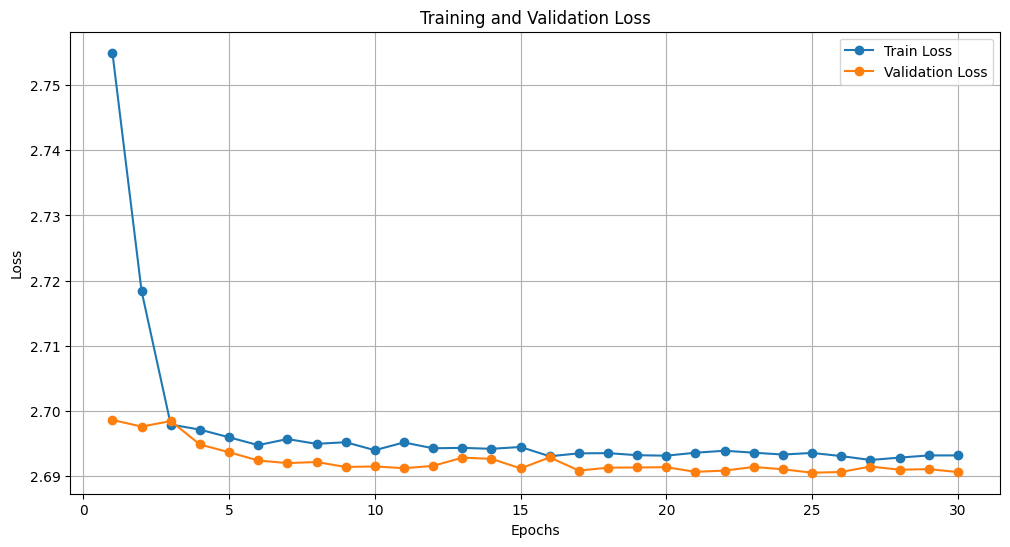

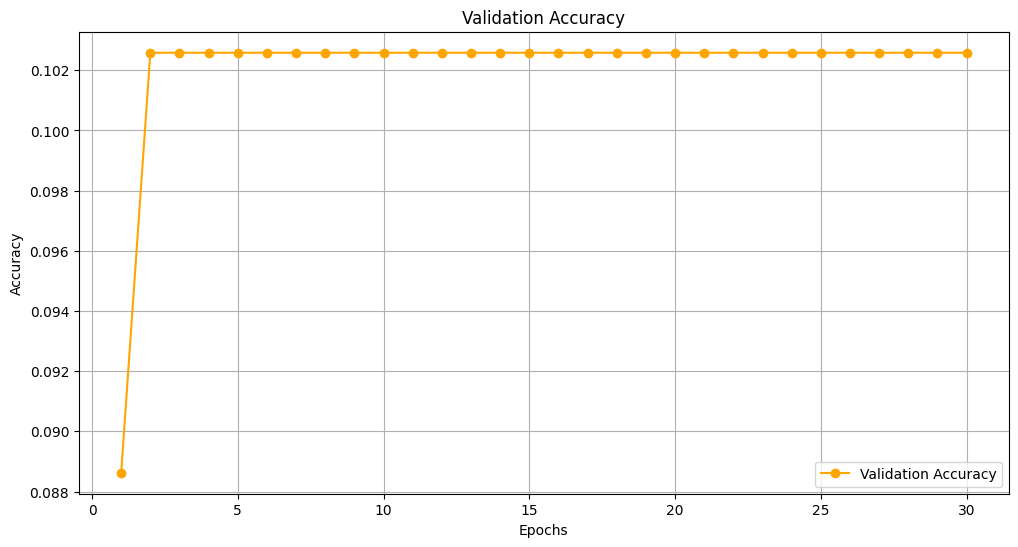

In [6]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), metrics["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), metrics["val_accuracy"], label="Validation Accuracy", marker='o', color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()
